# Objektdefinition

## 1. Importe

Zuerst importieren wir ein paar benötigte Pakete.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
%matplotlib inline

from standard_config import *
import sys

sys.path.append("{}/utils/io".format(local_home_path))
import file_io as fio
import io_config as ioc

sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

import glob
from ipywidgets import *

from skimage.morphology import h_minima
from scipy import ndimage as ndi

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

import MSGtools as mst
import pandas as pd

import fixed_colourbar as fc

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# 2. Beispielfall

Danach laden wir uns einen Beispielfall, versuchen ein Objekt zu finden und analysieren die Minimumtemepratur im IR-10,8-µm-Feld über die Zeit.

## 2.1 Beispielfall laden

In [2]:
haci_cases = glob.glob("{}/*.nc".format(ioc.haci_track_data_path))

In [3]:
example_case = fio.read_nc_file(haci_cases[100])

In [4]:
def plot_haci_case(case_data):
    from plotting_tools.colormaps import enhanced_colormap2
    emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)
    
    from plotting_tools.colormaps import radar_cmap as rc
    
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].pcolormesh(case_data['slon'],case_data['slat'],ir,vmin=210,vmax=300,cmap=emap)
        p1 = axs[i].contourf(case_data['rlon'],
                             case_data['rlat'],
                             np.ma.masked_greater(np.ma.masked_less(case_data['rx'][i],5),70),
                             np.arange(5,75,5),
                             vmin=5,vmax=70,cmap=rc(),
                             alpha=0.5)
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                       unit='m',
                                                                       timezone='UTC'),
                                         (i*5) - 30))

    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'RX / dBZ')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig           

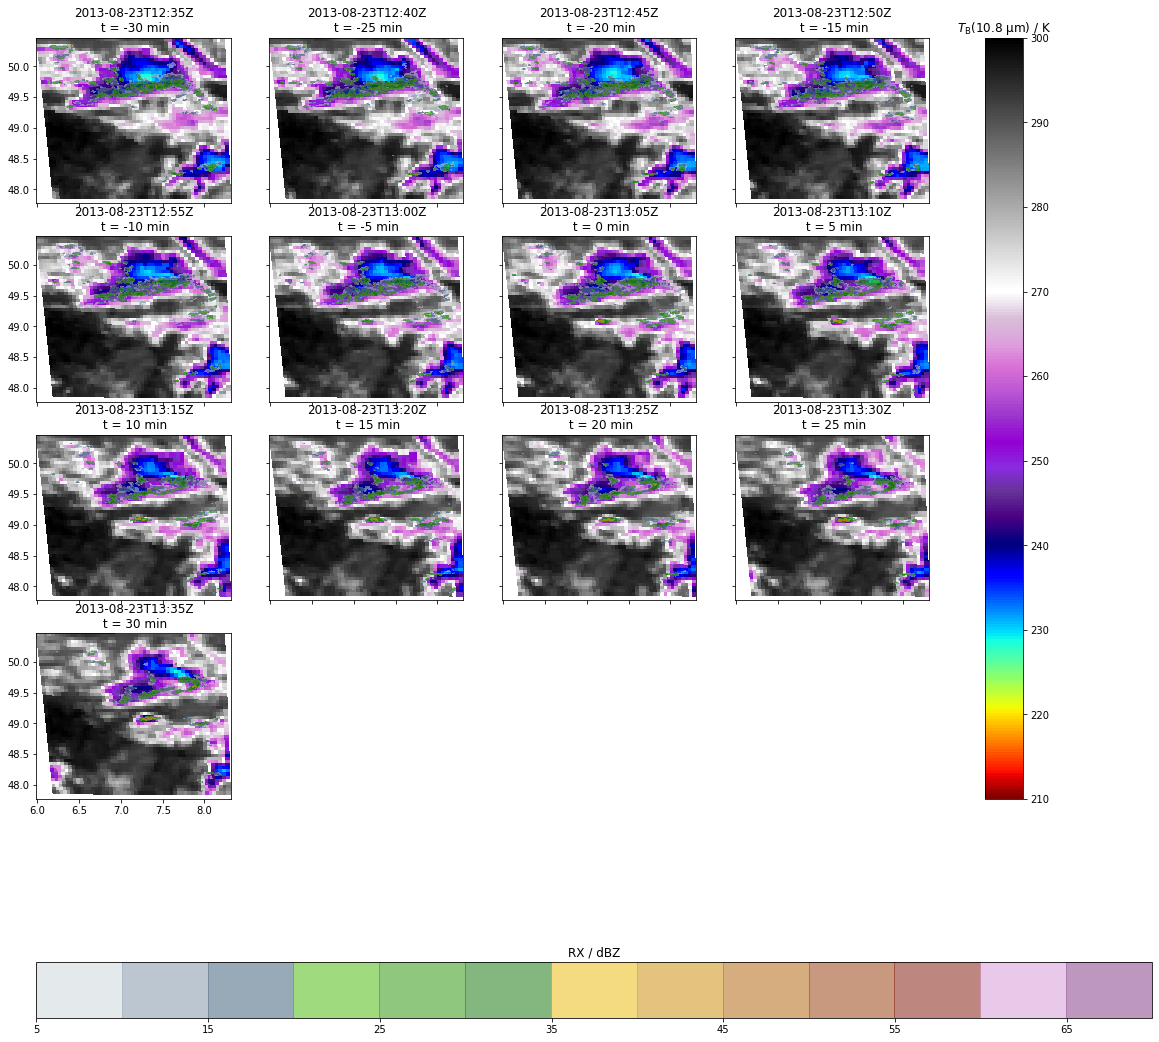

In [5]:
fig = plot_haci_case(example_case)

Das sieht doch gar nicht so schlecht aus. Es ist kein Fall bei dem viel passiert, aber eine vernüftige Objektdefinition sollte möglich sein.

In [5]:
case_objects = np.array([oseg.segment_local_threshold(ir,7,273.15,220,240,5) for ir in example_case['ir108']])

In [6]:
def plot_case_object(case_data,object_data):
        
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].imshow(ir,vmin=210,vmax=300,cmap='gray_r')
        p1 = axs[i].imshow(np.ma.masked_less(object_data[i],1),alpha=0.6,vmin=1,vmax=np.max(object_data))
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                        unit='m',
                                                                        timezone='UTC'),
                                                  (i*5) - 30)
                                                 )
    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'Objektnummer')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig           

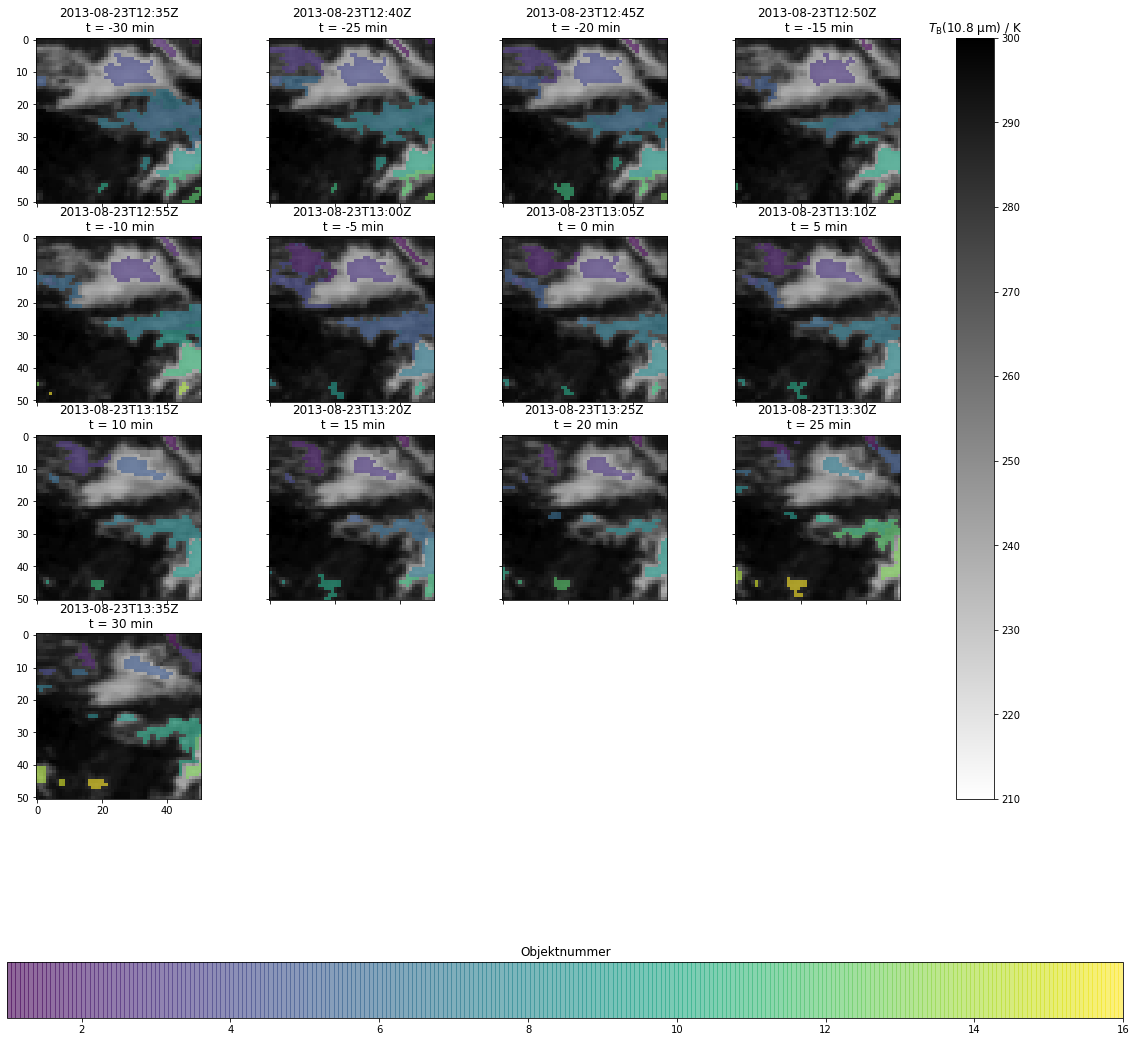

In [7]:
fig = plot_case_object(example_case,case_objects)

In [9]:
from importlib import reload

In [10]:
reload(oseg)

<module 'segmentation' from '/vols/satellite/home/lenk/utils/tracking/segmentation.py'>

In [8]:
@interact
def plot_object_definitions(t = (0,12),depth=(0,20),spread=(0,25),t_min=(180,240),t_max=(240,300),t_level=(200,270)):
    #case_object = np.array([oseg.segment_local_threshold(ir,depth,t_max,t_min,t_level,spread) for ir in example_case['ir108']])
    case_object = oseg.segment_local_threshold(example_case['ir108'][t],depth,t_max,t_min,t_level,spread,0,300)
    #plot_case_object(example_case,case_object)
    
    lmins = h_minima(example_case['ir108'][t],depth)
    lmins_labeled = ndi.label(lmins)[0]
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(example_case['ir108'][t],vmin=210,vmax=300,cmap='gray_r')#,cmap=emap)
    ax.imshow(np.ma.masked_less(case_object,1),cmap='nipy_spectral',alpha=0.8)
    #ax.contour(case_object,np.unique(case_object)[1:],cmap='inferno')    
    #ax.imshow(np.ma.masked_less(lmins,1),alpha=0.8,cmap='Reds')
    
    for lm in np.unique(lmins_labeled):
        lm_loc = np.where(lmins_labeled==lm)
        ax.plot(np.min(lm_loc[1]),np.min(lm_loc[0]),'r+')
        ax.text(np.min(lm_loc[1]),
                np.min(lm_loc[0]),
                "{:.1f} K".format(np.unique(example_case['ir108'][t][lm_loc])[0]),c='r')

interactive(children=(IntSlider(value=6, description='t', max=12), IntSlider(value=10, description='depth', ma…

In [9]:
field = example_case['ir108'][6]

In [10]:
minima = h_minima(field,7)

In [11]:
local_minima_field, nlabels = oseg.get_labeled_local_minima(field,7,0)

In [12]:
minima_label = np.arange(1,nlabels)

In [13]:
tlimit= 300

In [14]:
# create dictionary to store the values of the local minima
minima_values = {ml:[] for ml in minima_label}

# collect the position and the values of the local minima
for ml in minima_label:
    ml_location = np.where(local_minima_field==ml)

    if np.all(local_minima_field[ml_location[0][0],ml_location[1][0]] < tlimit): 
        minima_values[ml] = [ml_location[0][0], 
                             ml_location[1][0],
                             field[ml_location][0],
                             oseg.local_threshold(field[ml_location][0])]
    else:
        continue

In [15]:
minima_values

{1: [0, 39, 239.2945, 253.39981410630293],
 2: [8, 11, 258.601, 272.7987600940734],
 3: [11, 35, 228.69480000000001, 240.0],
 4: [13, 4, 256.5158, 271.3792077207902],
 5: [14, 9, 263.67810000000003, 275.5709522180621],
 6: [26, 24, 252.37310000000002, 268.07353577403575],
 7: [27, 40, 253.5797, 269.10299826735655],
 8: [39, 48, 231.79520000000002, 242.0823897828787],
 9: [45, 1, 270.1137, 277.69091029746],
 10: [46, 19, 282.192, 287.192],
 11: [47, 46, 235.52640000000002, 247.97778406472253]}

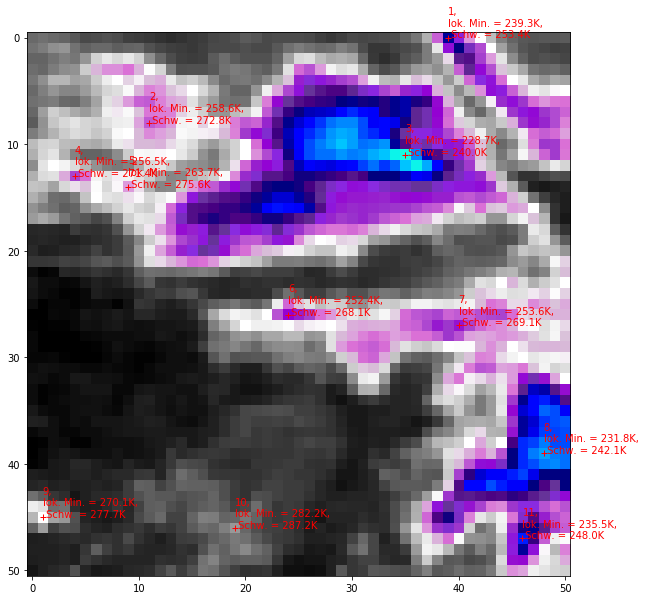

In [16]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap=emap)

for m in minima_values.keys():
    ax.plot(minima_values[m][1],
            minima_values[m][0],'r+')
    ax.text(minima_values[m][1],
            minima_values[m][0],
            "{},\nlok. Min. = {:.1f}K,\n Schw. = {:.1f}K".format(m,minima_values[m][2],minima_values[m][3]),c='r')

In [17]:
local_minimum = 6

In [18]:
minima_values[local_minimum]

[26, 24, 252.37310000000002, 268.07353577403575]

In [19]:
lower_mask = np.ma.masked_less(field,minima_values[local_minimum][3])
upper_mask = np.ma.masked_greater_equal(field,minima_values[local_minimum][2])

In [20]:
def range_colourmap(vmin=210,vthresh=240,vlmin=270,vmax=300):
    nfull = 256

    nwarm = int(np.rint(nfull * (vmax - vlmin) / (vmax - vmin)))
    nright = int(np.rint(nfull * (vlmin - vthresh) / (vmax - vmin)))
    ncool = nfull - nwarm - nright

      
    colors1 = plt.cm.gray_r(np.linspace(0., 1., nwarm))
    colors2 = plt.cm.Wistia_r(np.linspace(0.,1.,nright))
    colors3 = plt.cm.cool_r(np.linspace(0, 1., ncool))

    # combine them and build a new colormap
    colors = np.vstack((colors3,colors2, colors1))
    mymap = mcolor.LinearSegmentedColormap.from_list('object_cmap', colors)


    return mymap

In [21]:
rmap = range_colourmap(vmin = 210,
                       vthresh = minima_values[local_minimum][2],
                       vlmin = minima_values[local_minimum][3],
                       vmax = 300)

Text(0.5, 1.0, 'für Objekt in Frage\nkommende Bereiche')

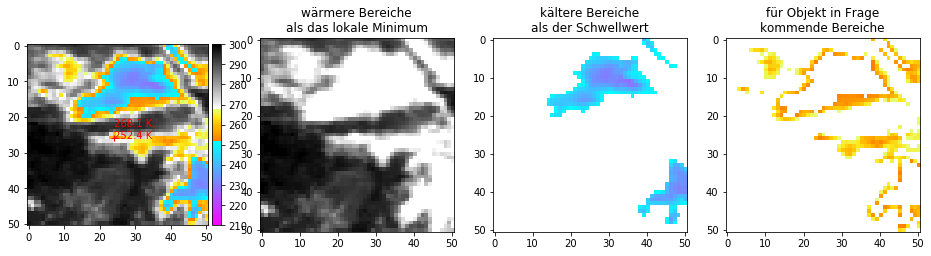

In [22]:
fig,ax = plt.subplots(1,4,figsize=(16,4))
p = ax[0].imshow(example_case['ir108'][6],
                 vmin=210,
                 vmax=300,
                 cmap=rmap)
fc.colourbar(p)
ax[0].plot(minima_values[local_minimum][1],
           minima_values[local_minimum][0],'r+')
ax[0].text(minima_values[local_minimum][1],
           minima_values[local_minimum][0],
            "{:.1f} K,\n{:.1f} K".format(minima_values[local_minimum][3],
                                        minima_values[local_minimum][2]),c='r')

ax[1].imshow(lower_mask,
             vmin=210,
             vmax=300,
             cmap=rmap)
ax[1].set_title("wärmere Bereiche\nals das lokale Minimum")

ax[2].imshow(upper_mask,
             vmin=210,
             vmax=300,
             cmap=rmap)
ax[2].set_title("kältere Bereiche\nals der Schwellwert")
ax[3].imshow(np.ma.masked_where(lower_mask.mask & upper_mask.mask == False,example_case['ir108'][6]),
             vmin=210,
             vmax=300,
             cmap=rmap)
ax[3].set_title("für Objekt in Frage\nkommende Bereiche")

In [23]:
threshold_mask = upper_mask.mask & lower_mask.mask

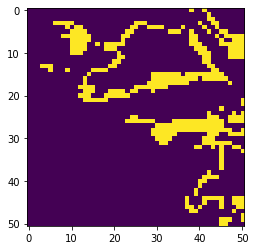

In [24]:
plt.imshow(threshold_mask)

In [25]:
threshold_mask_labeled = ndi.label(threshold_mask*1)[0]

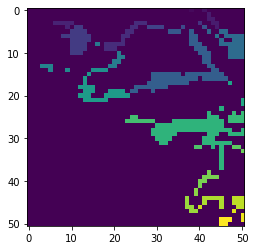

In [26]:
plt.imshow(threshold_mask_labeled)

In [27]:
obj_id = np.unique(threshold_mask_labeled[minima_values[local_minimum][0],
                                          minima_values[local_minimum][1]])

In [28]:
obj_id

array([28], dtype=int32)

In [29]:
obj_location = np.where(threshold_mask_labeled==obj_id)

In [30]:
obj_location

(array([25, 25, 26, 26, 26, 26, 26, 26, 26]),
 array([24, 25, 23, 24, 25, 26, 27, 28, 29]))

In [35]:
from scipy import ndimage as ndi

In [42]:
local_minimum = 7

In [43]:
lower_mask = np.ma.masked_less(field,minima_values[local_minimum][3])
upper_mask = np.ma.masked_greater_equal(field,minima_values[local_minimum][2])

In [44]:
threshold_mask = upper_mask.mask & lower_mask.mask

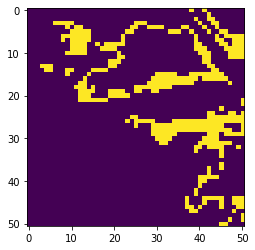

In [45]:
plt.imshow(threshold_mask)

In [46]:
threshold_mask_labeled = ndi.label(threshold_mask*1)[0]

# get label for the wanted object
obj_id = np.unique(threshold_mask_labeled[minima_values[local_minimum][0],
                                          minima_values[local_minimum][1]])#[0]

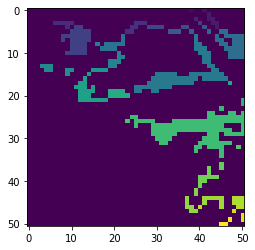

In [47]:
plt.imshow(threshold_mask_labeled)

In [48]:
threshold_mask_labeled[threshold_mask_labeled!=obj_id] = 0

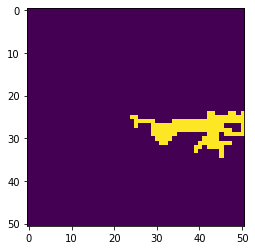

In [49]:
plt.imshow(threshold_mask_labeled)

In [50]:
threshold_mask_filled = ndi.binary_fill_holes(threshold_mask_labeled)

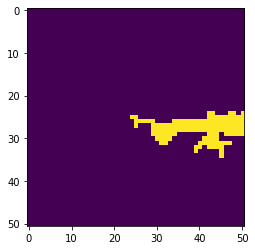

In [51]:
plt.imshow(threshold_mask_filled)

In [52]:
# calculate the local threshold for the local minima and store them
segmented_field = np.zeros_like(field,dtype="uint16")


for local_minimum in minima_values.keys():
    if np.isnan(minima_values[local_minimum][3]):
        continue
    else:
        # create masks with areas which inbetween the thresholds
        lower_mask = np.ma.masked_less(field,minima_values[local_minimum][3])
        upper_mask = np.ma.masked_greater_equal(field,minima_values[local_minimum][2])
        
        #threshold_mask = np.ma.masked_less_equal(field,
        #                                         minima_values[local_minimum][3]).mask*1 

        threshold_mask = upper_mask.mask & lower_mask.mask
        
        # label those areas
        threshold_mask_labeled = ndi.label(threshold_mask*1)[0]
        
        # get label for the wanted object
        obj_id = np.unique(threshold_mask_labeled[minima_values[local_minimum][0],
                                                  minima_values[local_minimum][1]])#[0]
        # only retain wanted object
        threshold_mask_labeled[threshold_mask_labeled!=obj_id] = 0
        
        # fill possible holes within the object
        
        threshold_mask_labeled = ndi.binary_fill_holes(threshold_mask_labeled)
        
        # get the points of this object
        obj_location = np.where(threshold_mask_labeled==1)
        
        # check, if there is already an object
        segment_values = np.unique(segmented_field[obj_location])
        
        # if all are zero, we simply label these values as belonging to the object
        if np.all(segment_values == 0):
            segmented_field[obj_location] = local_minimum
        # if not we only label those values, which are zero
        else:
            zero_loc = np.where(segmented_field[obj_location]==0)
            loc = (obj_location[0][zero_loc],obj_location[1][zero_loc])
            segmented_field[loc] = local_minimum

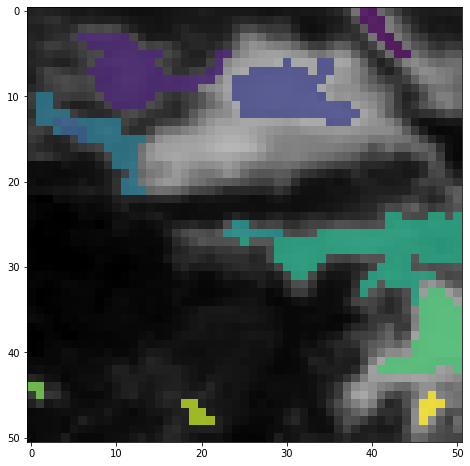

In [55]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(field,vmin=210,vmax=300,cmap='gray_r')
ax.imshow(np.ma.masked_less(segmented_field,1),alpha=0.8)

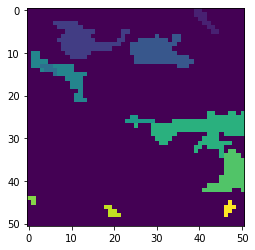

In [56]:
plt.imshow(oseg.segment_local_threshold(field,
                                        minimum_depth = 7,
                                        tmax = 273.15,
                                        tmin = 220,
                                        thresh_min = 240,
                                        spread = 10,
                                        tlimit=300))

In [43]:
from scipy import ndimage as ndi
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

In [103]:
test_mins = h_minima(example_case['ir108'][5],5)

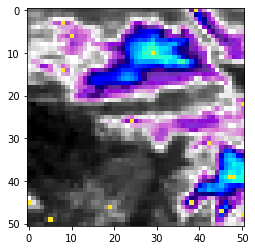

In [105]:
plt.imshow(example_case['ir108'][5],vmin=210,vmax=300,cmap=emap)
plt.imshow(np.ma.masked_less(test_mins,1),cmap='viridis_r')

In [106]:
test_mins_labeled = ndi.label(test_mins)[0]

In [114]:
values = {label:{'value':[],'threshold':[],'column':[],'row':[]} for label in np.unique(test_mins_labeled)[1:]}
threshold_map = np.full_like(example_case['ir108'][5],300)

for label in np.unique(test_mins_labeled)[1:]:
    label_loc = np.where(test_mins_labeled==label)
    
    if label_loc[0].size > 1:
        label_loc = (np.array([int(np.rint(np.mean(label_loc[0])))]),
                     np.array([int(np.rint(np.mean(label_loc[1])))]))
        
    thresh = oseg.local_threshold(example_case['ir108'][5][label_loc])
    
    values[label]['threshold'] = thresh#[0]
    values[label]['value'] = example_case['ir108'][5][label_loc][0]
    values[label]['column'] = label_loc[0][0]
    values[label]['row'] = label_loc[1][0]
    threshold_map[label_loc] = thresh#[0]

In [115]:
values

{1: {'value': 240.02280000000002,
  'threshold': array([254.38617347]),
  'column': 0,
  'row': 39},
 2: {'value': 261.5405,
  'threshold': array([274.52200395]),
  'column': 3,
  'row': 8},
 3: {'value': 259.16040000000004,
  'threshold': array([273.15175149]),
  'column': 6,
  'row': 10},
 4: {'value': 230.6862,
  'threshold': array([240.2291475]),
  'column': 10,
  'row': 29},
 5: {'value': 263.3256,
  'threshold': array([275.40981495]),
  'column': 14,
  'row': 8},
 6: {'value': 261.5405,
  'threshold': array([274.52200395]),
  'column': 22,
  'row': 50},
 7: {'value': 256.89910000000003,
  'threshold': array([271.65242237]),
  'column': 26,
  'row': 24},
 8: {'value': 258.601,
  'threshold': array([272.79876009]),
  'column': 31,
  'row': 42},
 9: {'value': 231.79520000000002,
  'threshold': array([242.08238978]),
  'column': 39,
  'row': 48},
 10: {'value': 271.57140000000004,
  'threshold': array([277.95461001]),
  'column': 45,
  'row': 0},
 11: {'value': 241.9267,
  'threshold

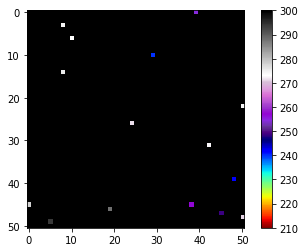

In [116]:
plt.imshow(threshold_map,vmin=210,vmax=300,cmap=emap)
plt.colorbar()

In [50]:
from skimage.morphology import watershed

In [117]:
segmented = watershed(example_case['ir108'][5],test_mins_labeled)

In [118]:
masks = []
for label in values.keys():
    mask = np.zeros_like(example_case['ir108'][5])
    
    mask = np.ma.masked_where(example_case['ir108'][5]< values[label]['threshold'],mask)
    
    masks.append(mask.mask)

In [119]:
maske = ~np.ma.masked_less(np.sum(masks,axis=0),1).mask

In [120]:
len(masks)

15

In [121]:
cma = mst.get_nwcsaf_prod("CMa",pd.Timestamp(example_case['time'][6]).to_pydatetime(),calibrate=True)

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/23/SAFNWC_MSG?_CMa__201308231305_rss-eu______.c?.h5  does not exist!


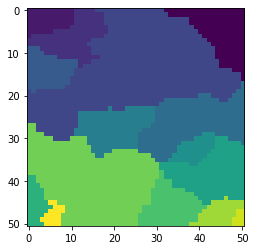

In [122]:
plt.imshow(segmented)

In [124]:
seg2 = watershed(example_case['ir108'][5],test_mins_labeled,mask=np.ma.masked_greater(example_case['cma'][5],1).mask)

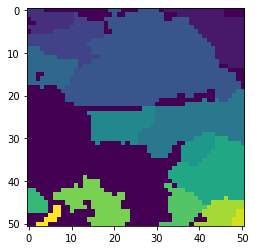

In [125]:
plt.imshow(seg2)

IndexError: index 12 is out of bounds for axis 0 with size 12

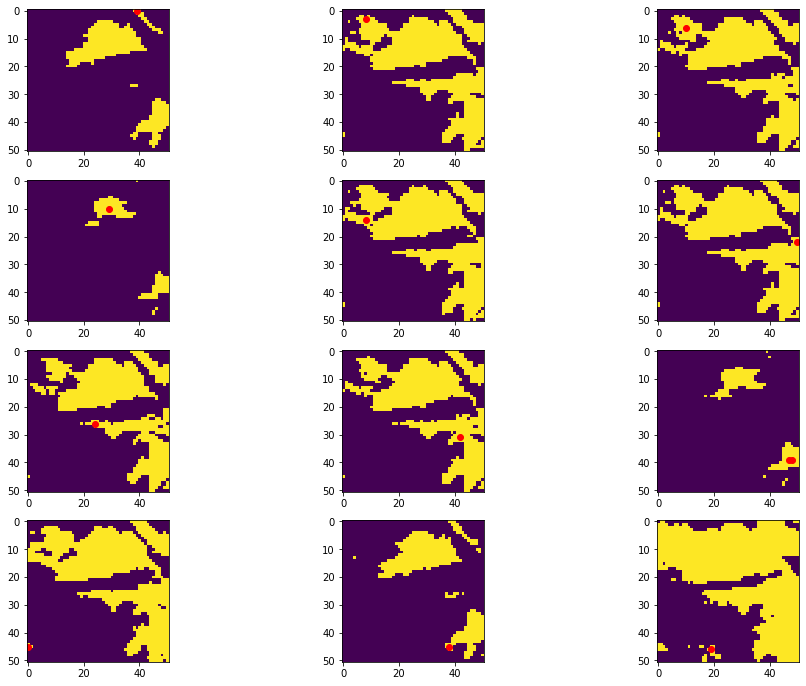

In [126]:
fig, ax = plt.subplots(4,3,figsize=(16,12))
axs = ax.ravel()

for i,m in enumerate(masks):
    axs[i].imshow(m)
    min_loc = np.where(test_mins_labeled==i+1)
    axs[i].plot(min_loc[1],min_loc[0],'ro')

Vielleicht ist es eine gute Idee nur die Bereiche, in denen das lokale Minimum liegt in die Maske aufzunehmen.

In [156]:
masks2 = [ ]
for label in values.keys():
    mask = np.zeros_like(example_case['ir108'][5])
    mask = np.ma.masked_where(example_case['ir108'][5] < values[label]['threshold'],mask)
    
    m_labeled = ndi.label(mask.mask*1)[0]
    min_label = m_labeled[values[label]['column'],values[label]['row']]
    
    omask = np.full_like(example_case['ir108'][5],False)
    omask[np.where(m_labeled==min_label)] = True
    
    masks2.append(omask)

In [157]:
label = 1

In [158]:
mask = np.zeros_like(example_case['ir108'][5])
mask = np.ma.masked_where(example_case['ir108'][5]< values[label]['threshold'],mask)

In [159]:
m_labeled = ndi.label(mask.mask*1)[0]

In [160]:
min_label = m_labeled[values[label]['column'],values[label]['row']]

In [161]:
min_label

1

In [162]:
mask = np.full_like(example_case['ir108'][5],False)

In [163]:
mask[np.where(m_labeled==min_label)] = True

In [164]:
np.where(m_labeled==min_label)

(array([0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 7, 8, 8]),
 array([38, 39, 40, 39, 40, 41, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45,
        46, 47, 47, 48]))

(30, 0)

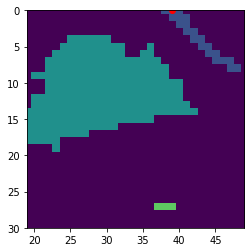

In [165]:
plt.imshow(m_labeled)
plt.plot(values[label]['row'],values[label]['column'],'ro')
plt.xlim(19,49)
plt.ylim(30,0)
#plt.colorbar()

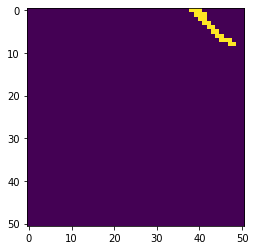

In [166]:
plt.imshow(mask)

IndexError: index 12 is out of bounds for axis 0 with size 12

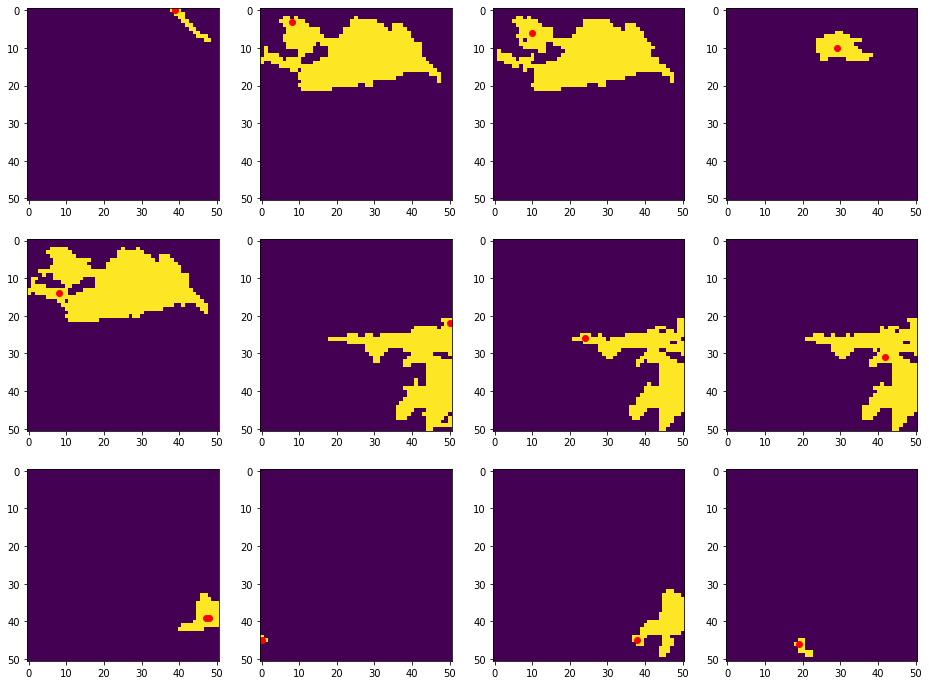

In [167]:
fig, ax = plt.subplots(3,4,figsize=(16,12))
axs = ax.ravel()

for i,m in enumerate(masks2):
    axs[i].imshow(m)
    min_loc = np.where(test_mins_labeled==i+1)
    axs[i].plot(min_loc[1],min_loc[0],'ro')

Damit könnte man sich wahrscheinlich die ganze Watershed-Transformation sparen. Aber mal sehen.

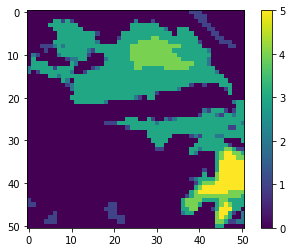

In [168]:
plt.imshow(np.sum(masks2,axis=0))
plt.colorbar()

In [169]:
maske2 = np.sum(masks2,axis=0)

In [170]:
segmented2 = watershed(example_case['ir108'][5], test_mins_labeled, mask=maske2)#, watershed_line=True)
case_object = oseg.segment_local_threshold(example_case['ir108'][5],6,273.15,220,240,5,0)

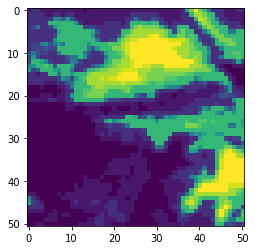

In [171]:
plt.imshow(np.sum(masks,axis=0))

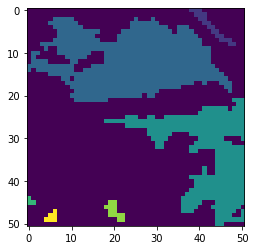

In [172]:
plt.imshow(ndi.label(maske2)[0])

Text(0.5, 1.0, 'Methode mit Watershed')

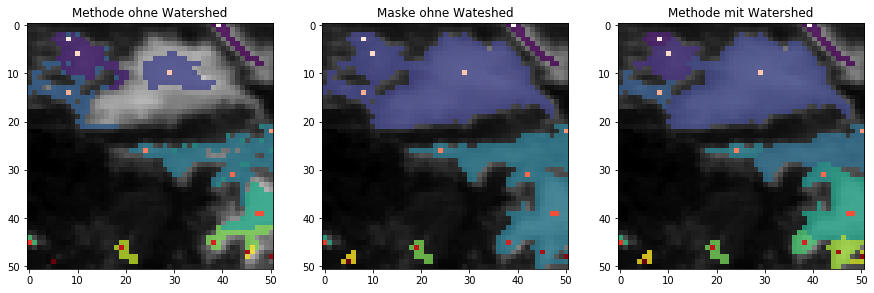

In [173]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[0].imshow(np.ma.masked_less(case_object,1),alpha=0.8)
ax[0].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[0].set_title("Methode ohne Watershed")

ax[1].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[1].imshow(np.ma.masked_less(ndi.label(maske2)[0],1),alpha=0.8)
ax[1].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[1].set_title("Maske ohne Wateshed")

ax[2].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[2].imshow(np.ma.masked_less(segmented2,1),alpha=0.8)
ax[2].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[2].set_title("Methode mit Watershed")

Bei der Methode ohne Watershed werden, wie zu erwarten die Kernbereiche der Wolke selektiert. Wenn allerdings Bereiche in mehreren Objekten liegen könnten, ist die Zuordnung mehr oder weniger Zufall. Bei der Methode mit der Watershedsegmentierung werden viel zu große Bereiche ausgewählt. Da läuft bei der Maskenbildung etwas gründlich schief. Um die Zuordnung der Objekte aber bei der ersten Methode zu verbessern, könnte man die Objektzuordungen als Maske für eine folgende Watershedsegmentierung nehmen und so beide Ansätze kombinieren.

In [174]:
combined = watershed(example_case['ir108'][5], test_mins_labeled, mask=np.ma.masked_greater(case_object,0).mask)

Text(0.5, 1.0, 'Objekte mit Neuverteilung\ndurch Watershed')

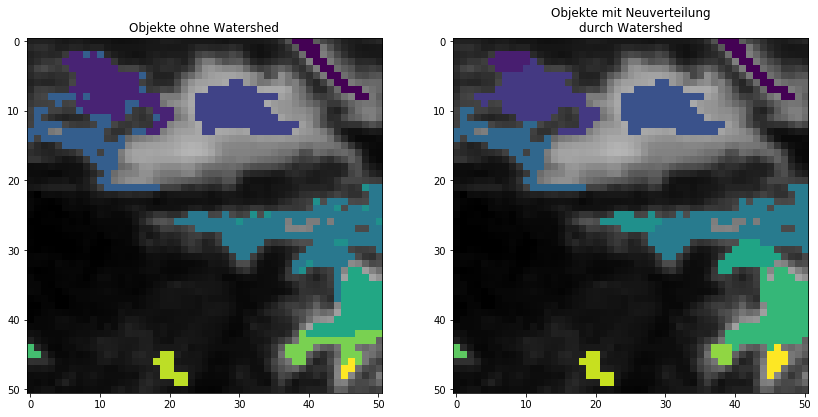

In [175]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
ax[0].imshow(example_case['ir108'][5],vmin=210,vmax=300,cmap='gray_r')
ax[0].imshow(np.ma.masked_less(case_object,1))
ax[0].set_title("Objekte ohne Watershed")
ax[1].imshow(example_case['ir108'][5],vmin=210,vmax=300,cmap='gray_r')
ax[1].imshow(np.ma.masked_less(combined,1))
ax[1].set_title("Objekte mit Neuverteilung\ndurch Watershed")

Bei dem Ansatz mit den beiden Masken werden die Objekte im Großen und ganzen recht sinnvoll verteilt, allerdings ergeben sich Unstimmigkeiten, wenn Objekte aneinander stoßen. Dabei werden z.\thinsp;B. die beiden Objekte oben rechts im Ausschnitt seltsam zugeordnet. Durch eine Watershedtransformation sieht die Zuordnung stimmiger aus

In [7]:
objects_ws = []

for i in range(len(example_case['ir108'])):
    objects = oseg.watershed_local_min_segmentation(example_case['ir108'][i],7,220,273.15,240,5,0)
    objects_ws.append(objects)

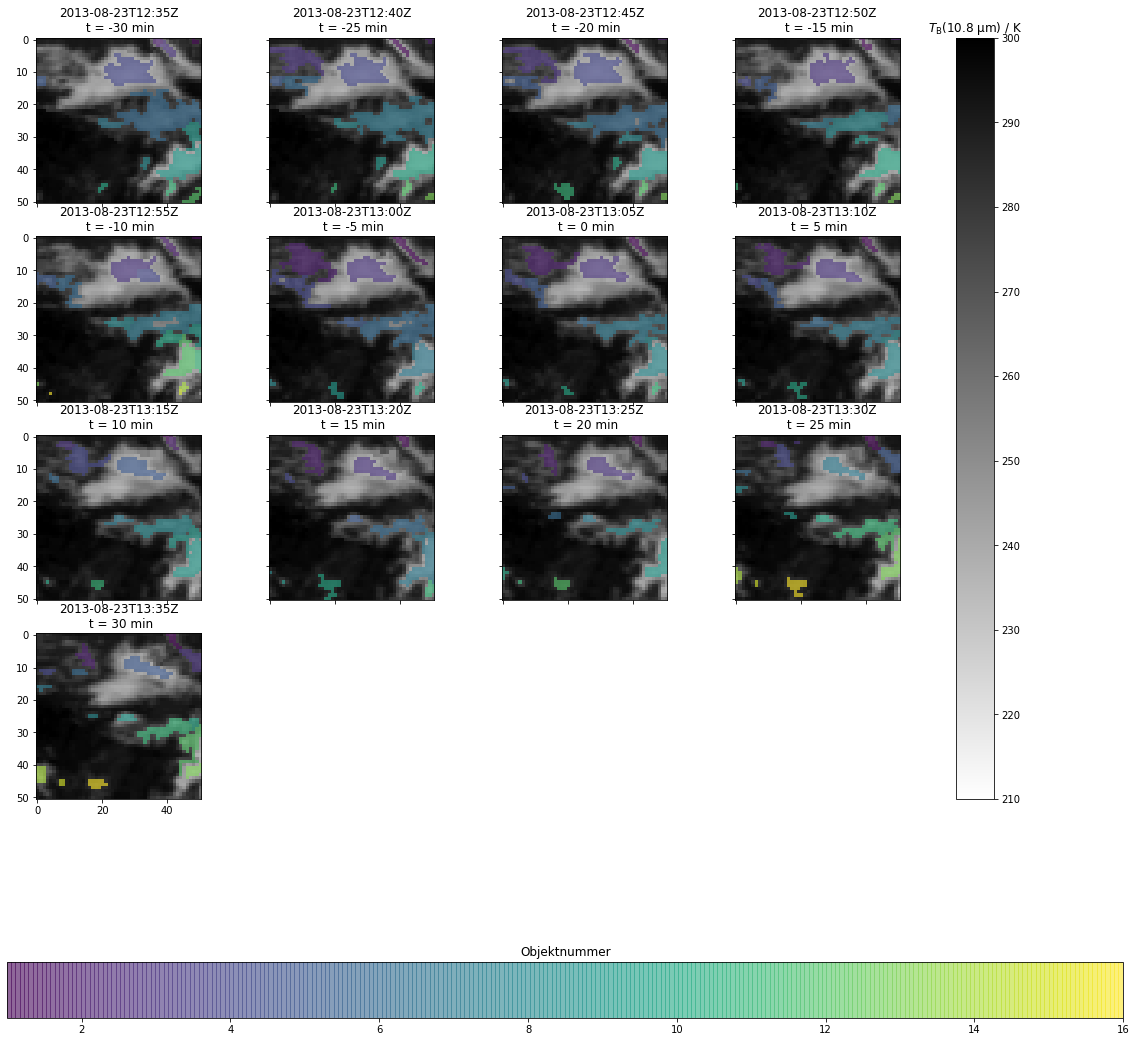

In [177]:
fig = plot_case_object(example_case,objects_ws)

Das sieht für diesen Fall im Großen und Ganzen recht stimmig aus. Seltsam ist nur, dass in manchen Objekten Löcher auftreten. Das sind immer Bereiche, die kälter als das ausgewählte lokale Minimum sind. Diese Bereiche sollten also folglich eigene Objekte sein, sind es aber vielleicht nicht geworden, weil diese lokalen Minima als nicht tief genug verworfen wurden. Um diese Löcher zu füllen, können wir binary_fill_holes aus scipy.ndimage nutzen.

In [8]:
import scipy.ndimage as ndi

In [12]:
objects_filled =[]

for obj in objects_ws:
    objects_filled.append(ndi.binary_fill_holes(obj))

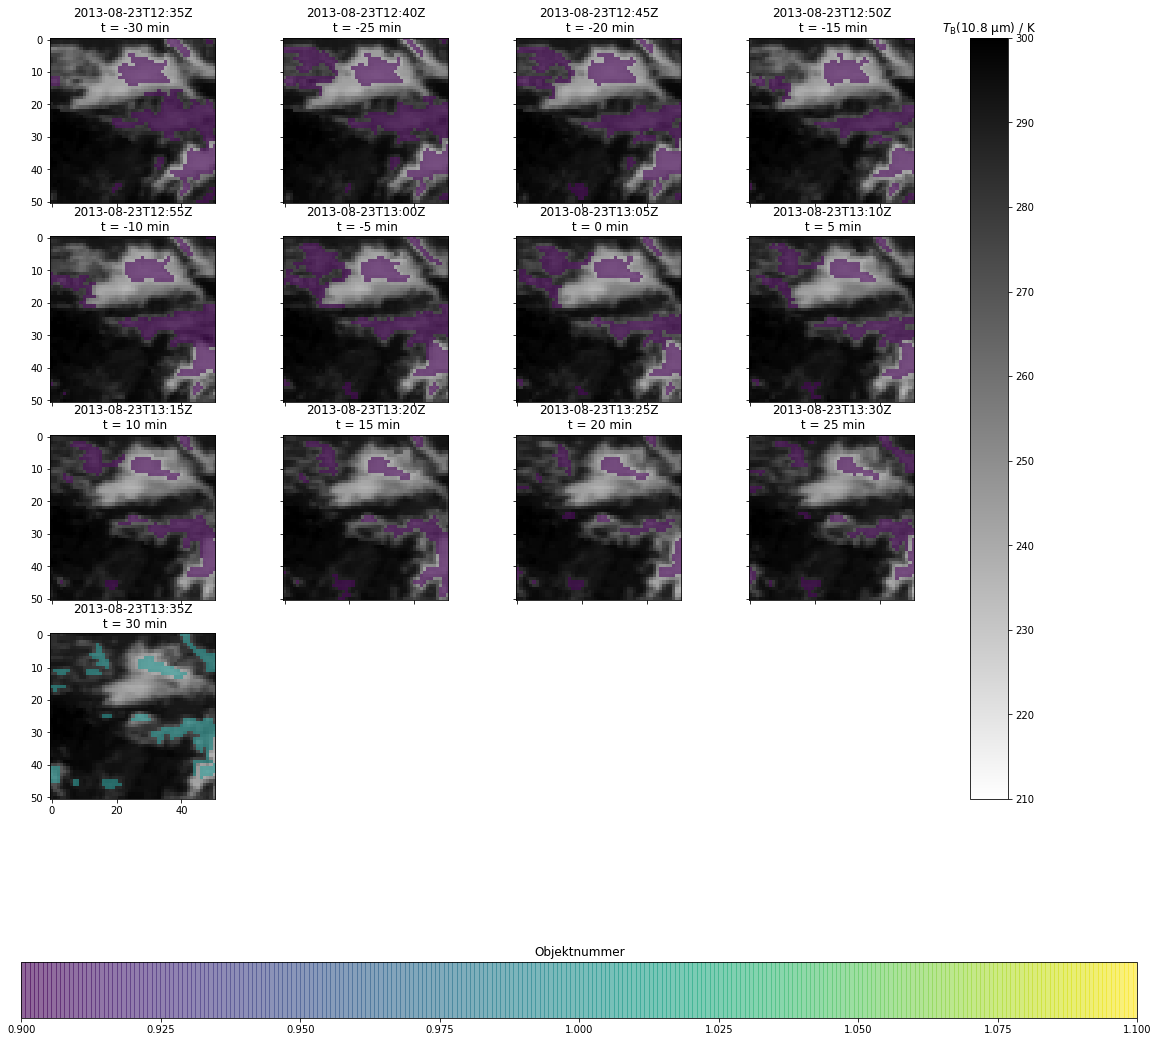

In [13]:
fig = plot_case_object(example_case,objects_filled)

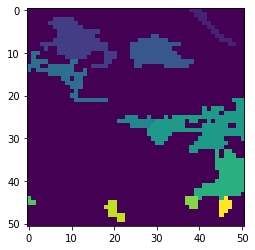

In [178]:
plt.imshow(oseg.watershed_local_min_segmentation(example_case['ir108'][5],6,220,273.15,240,5,0))

Als nächstes müssten wir durch alle Zeitschritte laufen und sehen, wie der Nachfolger im nächsten Schritt aussieht.

In [179]:
def link_objects(object_connections):

    tracks = []

    visited_oids = []
    for tid in object_connections.keys():
        for oid in object_connections[tid].keys():
            if oid in visited_oids:
                continue
            else:
                track = [oid]

                t = int(oid.split("_")[0])

                while t < len(object_connections.keys()):
                    try: 
                        oid = object_connections[t][oid][0]
                        track.append(oid)
                        visited_oids.append(oid)

                        t = int(oid.split("_")[0])
                    except:
                        break
                tracks.append(track)

    return tracks

In [180]:
len(objects_ws)

13

In [181]:
object_connections = {}

for i in range(1,len(objects_ws)):
    object_connections[i-1] = ot.find_successor_lakshmanan(objects_ws[i-1],objects_ws[i],i-1,i,2)

In [182]:
object_connections

{0: {'000_0001': ['001_0002'],
  '000_0002': ['001_0001'],
  '000_0003': ['001_0001'],
  '000_0004': ['001_0004'],
  '000_0005': ['001_0005'],
  '000_0006': ['001_0007'],
  '000_0007': ['001_0008'],
  '000_0008': ['001_0009'],
  '000_0009': ['001_0010'],
  '000_0010': ['001_0011'],
  '000_0011': ['001_0012'],
  '000_0012': ['001_0013']},
 1: {'001_0001': ['002_0001'],
  '001_0002': ['002_0002'],
  '001_0003': ['002_0003'],
  '001_0004': ['002_0004'],
  '001_0005': ['002_0005'],
  '001_0006': ['002_0005'],
  '001_0007': ['002_0006'],
  '001_0008': ['002_0007'],
  '001_0009': ['002_0010'],
  '001_0010': ['002_0009'],
  '001_0011': ['002_0011'],
  '001_0012': ['002_0012'],
  '001_0013': ['002_0013']},
 2: {'002_0001': ['003_0001'],
  '002_0002': ['003_0002'],
  '002_0003': ['003_0005'],
  '002_0004': ['003_0003'],
  '002_0005': ['003_0005'],
  '002_0006': ['003_0008'],
  '002_0007': ['003_0007'],
  '002_0008': ['003_0009'],
  '002_0009': ['003_0010'],
  '002_0012': ['003_0012'],
  '002_00

In [183]:
tracks = link_objects(object_connections)

In [184]:
tracks

[['000_0001', '001_0002', '002_0002', '003_0002', '004_0001'],
 ['000_0002',
  '001_0001',
  '002_0001',
  '003_0001',
  '004_0002',
  '005_0001',
  '006_0001',
  '007_0001',
  '008_0002',
  '009_0001',
  '010_0001',
  '011_0001',
  '012_0001'],
 ['000_0003',
  '001_0001',
  '002_0001',
  '003_0001',
  '004_0002',
  '005_0001',
  '006_0001',
  '007_0001',
  '008_0002',
  '009_0001',
  '010_0001',
  '011_0001',
  '012_0001'],
 ['000_0004',
  '001_0004',
  '002_0004',
  '003_0003',
  '004_0003',
  '005_0003',
  '006_0003',
  '007_0003',
  '008_0005',
  '009_0003',
  '010_0003',
  '011_0007',
  '012_0005'],
 ['000_0005',
  '001_0005',
  '002_0005',
  '003_0005',
  '004_0006',
  '005_0004',
  '006_0005',
  '007_0005',
  '008_0006',
  '009_0004',
  '010_0004'],
 ['000_0006',
  '001_0007',
  '002_0006',
  '003_0008',
  '004_0007',
  '005_0006',
  '006_0007',
  '007_0007',
  '008_0008',
  '009_0006',
  '010_0008',
  '011_0011',
  '012_0011'],
 ['000_0007',
  '001_0008',
  '002_0007',
  '003_0

Jetzt müssen wir nur noch den richtigen Track finden.

In [185]:
np.unique(objects_ws[6])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [186]:
object_id = ot.get_wanted_object_id(objects_ws)

In [187]:
object_id

6

In [188]:
wanted_track = []

for track in tracks:
    if "{:03d}_{:04d}".format(13//2,object_id) in track:
        wanted_track = track

In [189]:
"{:03d}_{:04d}".format(13//2,object_id)

'006_0006'

In [190]:
wanted_track

['000_0007',
 '001_0008',
 '002_0007',
 '003_0007',
 '004_0008',
 '005_0005',
 '006_0006',
 '007_0006',
 '008_0007',
 '009_0005',
 '010_0007',
 '011_0010',
 '012_0009']

In [191]:
wanted_object = ot.get_wanted_object_field(objects_ws,wanted_track)

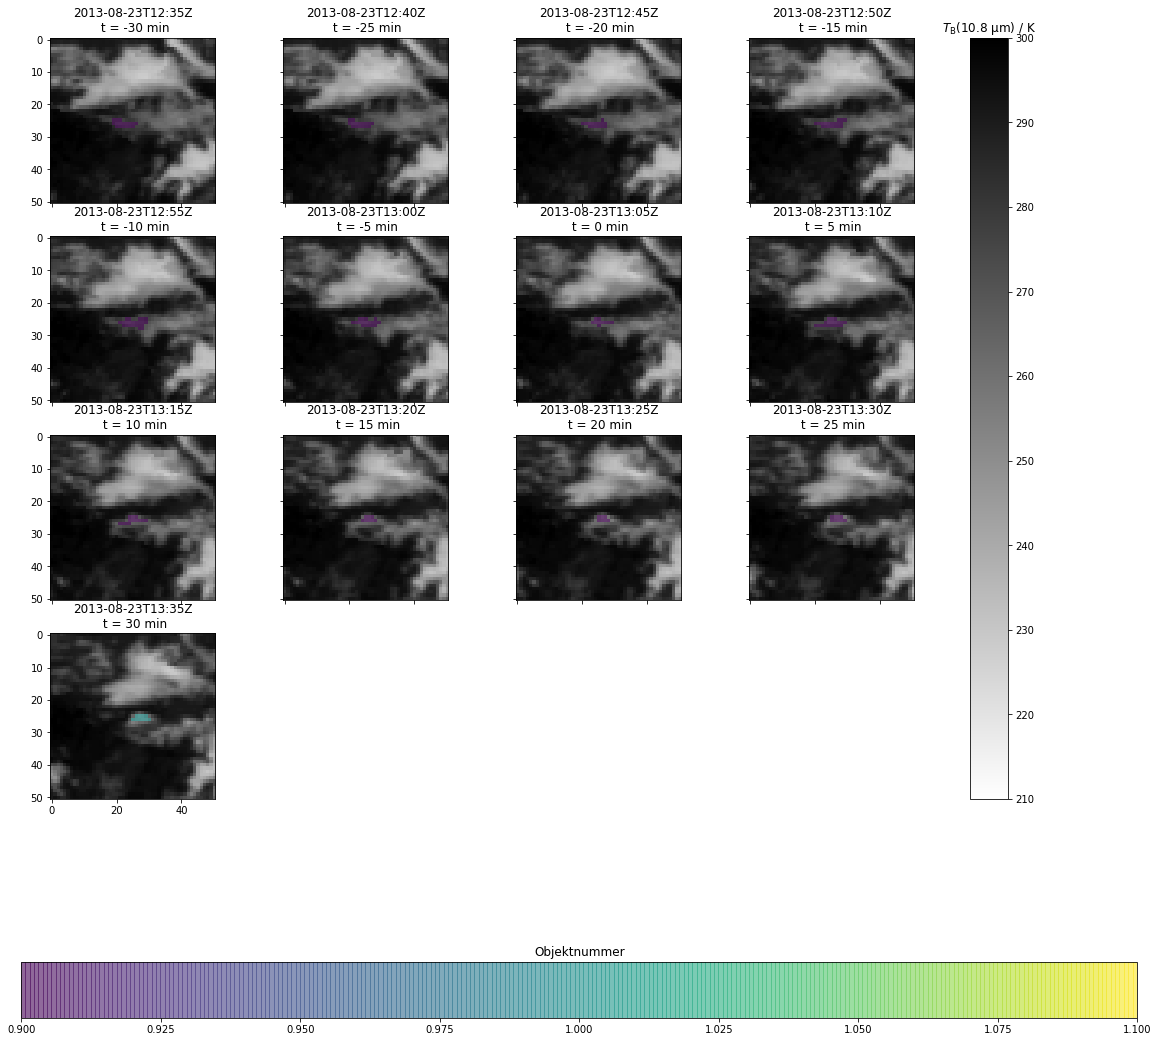

In [192]:
fig = plot_case_object(example_case,np.array(list(wanted_object.values())))

Dann können wir endlich Objekteigenschaften betrachten.

In [193]:
object_locations = dict()

for i,o in enumerate(wanted_object):
    object_locations[i] = np.where(wanted_object[i]==1)

In [194]:
values = []
times = []
field = []

for i in range(len(wanted_object)):
    for f in list(example_case.keys())[:15]:
        val = example_case[f][i][object_locations[i]]
        values.extend(val.tolist())
        
        times.extend([(i*5)-30]*len(val))
        field.extend([f]*len(val))

In [195]:
import pandas as pd
import seaborn as sns

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [196]:
case_df = pd.DataFrame({'value':values,'time':times,'field':field})

<Figure size 864x432 with 0 Axes>

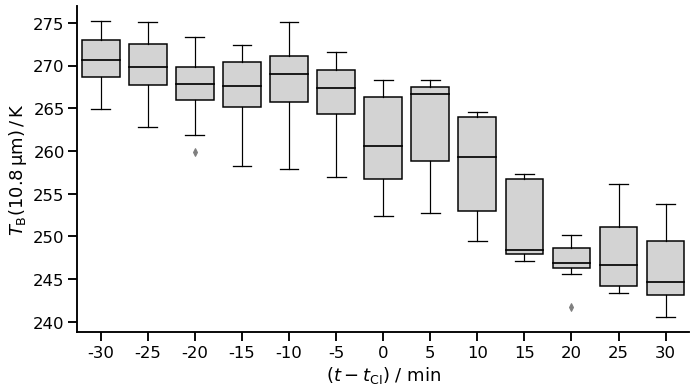

In [197]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_df[case_df['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

<Figure size 864x432 with 0 Axes>

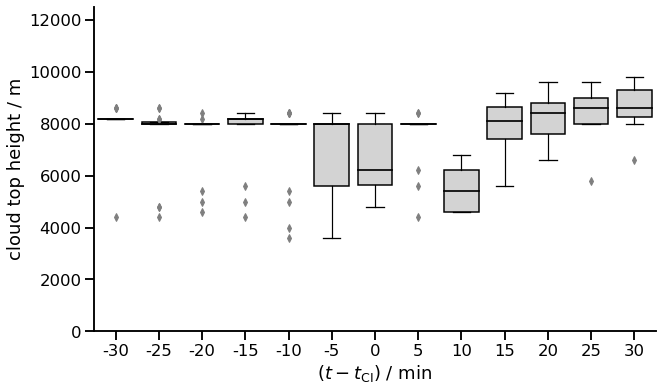

In [198]:
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_df[case_df['field']=='ctth'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel("cloud top height / m")
plt.ylim(0,12500)
plt.gcf().set_size_inches(12, 6)

In [199]:
def simple_T2h(T,T0=288,dT=6.5):
    return -((T-T0) / dT) * 1000

In [200]:
medians = case_df[case_df.field=='ir108'].groupby('time').median()

Das ist doch ein durchaus sinnvolles Objekt. Es wird nicht besonders kalt, aber es ist doch ein relativ typischer Lebenszyklus zu erkennen. Wir beginnen mit einem Objekt mit einem mittleren Temperatur von von ca. 271&thinsp;K und enden mit ca. 245&thinsp;K nach einer Stunde. Das entspricht bei einem adiabatischem Temperaturprofil einem Wachstum der Wolkenoberkante von 2300&thinsp;m auf ca. 4800&thinsp;m in einer Stunde und somit einem mittleren Aufwind von $\overline{w} = 7\,\frac{\mathrm{m}}{\mathrm{s}}$. Das zeigen auch die Wolkenhöhendaten, wenn auch nicht sehr deutlich. Wir haben bereits zu Begin Pixel mit Höhen etwa 8000&thinsp;m, aber auch sehr niedrige Bereiche. Eventuell sind hier im Objekt bereits Cirruswolken vorhanden. Nach der Stunde sind im Objekt keine niedrigen Pixel mehr vorhanden.

Wir können auch versuchen nur einen Wert pro Zeitpunkt für das Objekt zu berechnen, um am Ende daraus relativ robuste Zeittrends zu berechnen, die nicht mehr von einem richtigen Feldtracking abhängig sind. Für die Infrarotkanäle bietet sich das Objektminimum an, da kälter höher und damit gefährlicher ist. Man könnte auch den Mittelwert aus den 10&thinsp;% kältesten Pixeln berechnen, um nicht von nur einem Pixelwert abhängig zu sein.

In [206]:
object_ir108_value = []

In [207]:
for t in case_df['time'].unique():
    case_subset = case_df[case_df['time'] == t]
    n_values = len(case_subset[case_subset['field'] == 'ir108'])
    
    if n_values < 15:
        object_ir108_value.append(case_subset[case_subset['field'] == 'ir108']['value'].min())
    else:
        values_sorted = sorted(case_subset[case_subset['field'] == 'ir108']['value'])
        
        object_ir108_value.append(np.mean(values_sorted[:int(np.rint(n_values/10))]))

In [208]:
def aggregate_object_values(object_values,field='ir108',fraction=10,function='min'):
    aggregated_values = []
    
    functions = {'min':np.min,
                 'max':np.max,
                 'mean':np.mean,
                 'median':np.median}
    
    for t in object_values['time'].unique():
        subset = object_values[object_values['time'] == t]
        n_values = len(subset[subset['field'] == field])

        if n_values < 15:
            aggregated_values.append(functions[function](subset[subset['field'] == field]['value']))
        else:
            values_sorted = sorted(case_subset[case_subset['field'] == 'ir108']['value'])
            
            if function == 'min':    
                aggregated_values.append(np.mean(values_sorted[:int(np.rint(n_values/fraction))]))
            elif function == 'max':
                aggregated_values.append(np.mean(values_sorted[-int(np.rint(n_values/fraction)):]))
            else: 
                aggregated_values.append(functions[function](subset[subset['field'] == field]['value']))
                
    return aggregated_values

In [209]:
object_ir108_value = aggregate_object_values(case_df,function='min')

<Figure size 864x432 with 0 Axes>

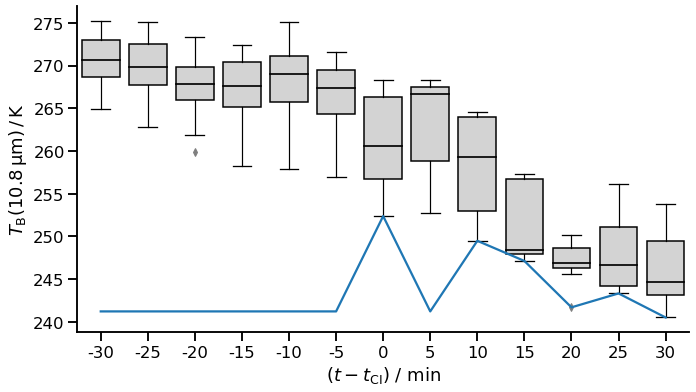

In [210]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_df[case_df['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

plt.plot(np.arange(0,13,1),object_ir108_value)

Nun sehen wir uns das für einen weiteren Fall an.


In [6]:
case = fio.read_nc_file(sorted(haci_cases)[0])

In [7]:
sns.set_context("talk")

NameError: name 'sns' is not defined

In [8]:
fig = plot_haci_case(case)

NameError: name 'plot_haci_case' is not defined

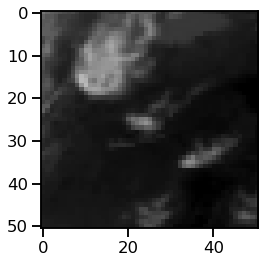

In [214]:
plt.imshow(case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')

In [9]:
case_objects = [oseg.watershed_local_min_segmentation(ir,7,220,273.15,240,5,0) for ir in case['ir108']]

In [10]:
case_objects

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 5, 5, 5],
        [0, 0, 0, ..., 5, 5, 5],
        [0, 0, 0, ..., 5, 5, 5]], dtype=int32), array([[0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4],
        [0, 0, 0, ..., 4, 4, 4]], dtype=int32), array([[ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  0,  1,  1],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11, 11, 11]], dtype=int32), array([[ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0, 11,  0],
        [ 0,  0,  0, ..., 11, 11, 11],
        [ 0,  0,  0, ..., 11,  0,  0]], dtype=int32), array([[0, 0, 0, ..., 1, 1,

In [11]:
objects, object_tracks = ot.track_objects_lmin_cost(case,'ir108','wv073',7,220,273.15,240,5,3,0)

In [228]:
ot.track_objects_lmin_cost??

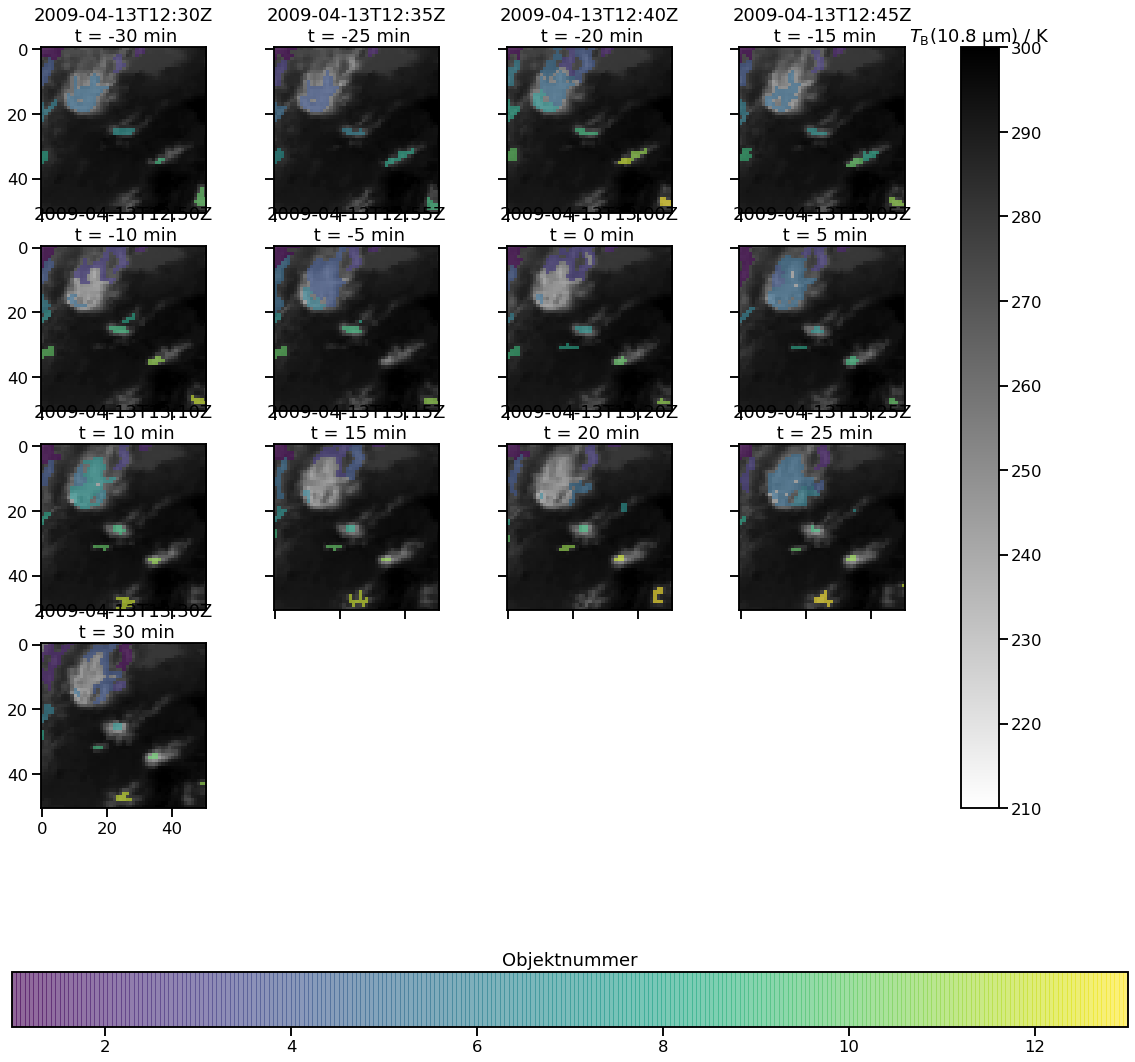

In [218]:
fig = plot_case_object(case,objects)

In [12]:
wanted_object_id = ot.get_wanted_object_id(objects)

In [13]:
wanted_track = ot.select_wanted_track_from_list(object_tracks,"{:03d}_{:04d}".format(len(objects)//2,wanted_object_id))

In [14]:
track_field = ot.get_wanted_object_field(objects,wanted_track)

In [15]:
track_field

{6: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 7: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 8: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 9: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 10: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0,

In [17]:
track_field_data = np.array(list(track_field.values()))
track_field_keys = np.array(list(track_field.keys()))

# check whether the object mask has the same length as the data
if np.min(track_field_keys) > 0:
    for i in np.arange(0,np.min(track_field_keys)):
        track_field[i] = np.zeros_like(track_field_data[0])
elif np.max(track_field_keys) < len(case_data['ir108']):
    for i in np.arange(np.max(track_field_keys),len(case_data['ir108'])):
        track_field[i] = np.zeros_like(track_field_data[0])

In [26]:
dict(sorted(track_field.items()))

{0: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 1: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 2: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 3: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 4: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

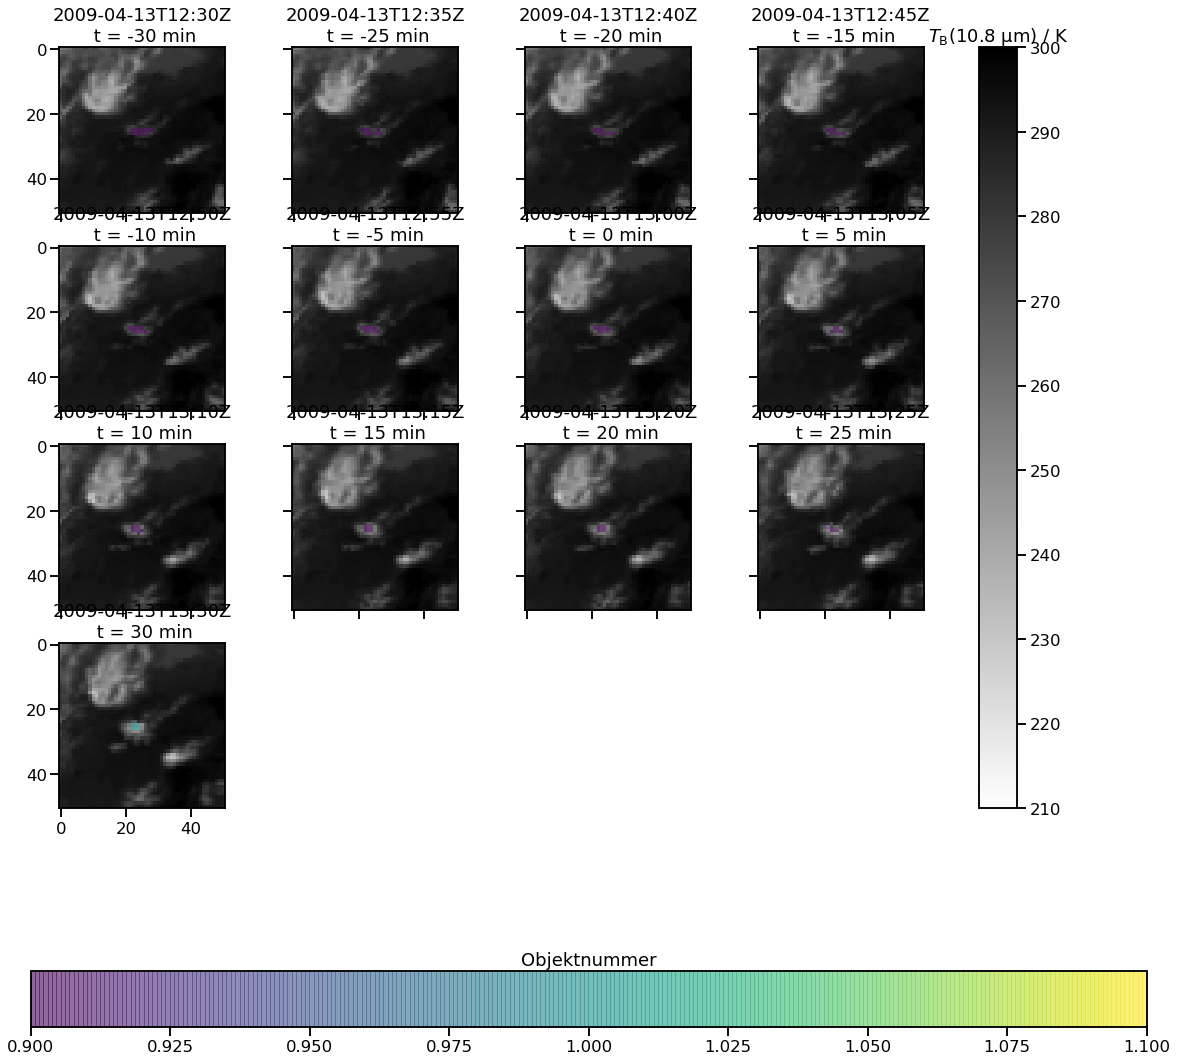

In [222]:
fig = plot_case_object(case,np.array(list(track_field.values())))

Das sieht auch gut aus!

In [223]:
object_locations = dict()

for i,o in enumerate(track_field):
    object_locations[i] = np.where(track_field[i]==1)
    
values = []
times = []
field = []

for i in range(len(wanted_object)):
    for f in list(case.keys())[:15]:
        val = case[f][i][object_locations[i]]
        values.extend(val.tolist())
        
        times.extend([(i*5)-30]*len(val))
        field.extend([f]*len(val))

In [224]:
case_value_df = pd.DataFrame({'value':values,
                              'time':times,
                              'field':field})

In [225]:
object_ir108_value = aggregate_object_values(case_value_df,function='min')
object_ir108_mean = aggregate_object_values(case_value_df,function='mean')

<Figure size 864x432 with 0 Axes>

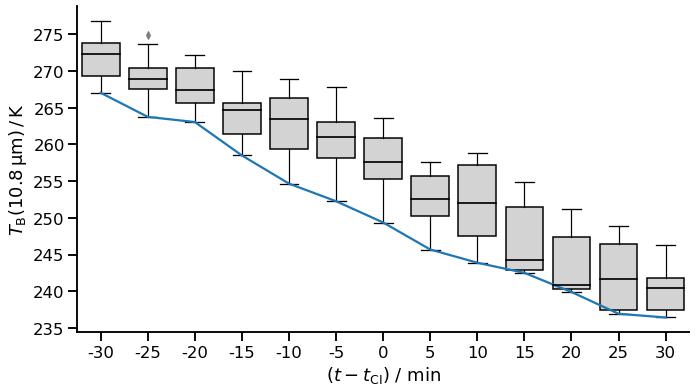

In [226]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_value_df[case_value_df['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

plt.plot(np.arange(0,13,1),object_ir108_value)

Das ist auch kein Fall mit besonders starker Konvektion. Aber es findet ein Wachstum der Wolke statt. Zu Beginn des Zeitausschnittes hat das Objekt eine mittlere Helligkeitstemperatur von etwa <i>T</i><sub>B</sub>={{"{:4.0f}".format(object_ir108_mean[0])}}&thinsp;K und nach einer Stunde von <i>T</i><sub>B</sub>={{"{:4.0f}".format(object_ir108_mean[-1])}}&thinsp;K. Entsprechend ergibt sich ein mittlerer Temperaturunterschied von &Delta;T&thinsp;=&thinsp;{{"{:4.0f}".format(object_ir108_mean[-1] - object_ir108_mean[0])}}&thinsp;K&thinsp;&middot;&thinsp;h<sup>-1</sup>. Das enspricht bei einem atmosphötischen Temperaturgradienten von d<i>T</i> = 6,5&thinsp;K&thinsp;km<sup>-1</sup> und <i>T</i><sub>Boden</sub>&thinsp;=&thinsp;293,95&thinsp;K einer mittleren Wolkenhöhe von h&thinsp;=&thinsp;{{"{:4.0f}".format(simple_T2h(object_ir108_mean[0],293.15,6.5))}}&thinsp;m und h&thinsp;=&thinsp;{{"{:4.0f}".format(simple_T2h(object_ir108_mean[-1],293.15,6.5))}}&thinsp;m und einem mittleren Höhenwachstum von &Delta;h&thinsp;=&thinsp;{{"{:4.0f}".format(simple_T2h(object_ir108_mean[-1],293.15,6.5) - simple_T2h(object_ir108_mean[0],293.15,6.5))}}&thinsp;m&thinsp;&middot;&thinsp;h<sup>-1</sup>. Das entspricht einer grob geschätzten mittleren Aufwindgeschwindigeit von $\overline{w} =$&thinsp;{{"{:4.0f}".format((simple_T2h(object_ir108_mean[-1],293.15,6.5) - simple_T2h(object_ir108_mean[0],293.15,6.5))/360)}}&thinsp;m&thinsp;&middot;&thinsp;s<sup>-1</sup>, was durchaus im stärkeren Aufwindbereich anzusiedeln ist.

In [27]:
import xarray as xr
ds = xr.open_dataset(sorted(haci_cases)[0])

In [28]:
ds0 = ds.copy(deep=True)

In [29]:
ds.close()

In [30]:
ds0

<xarray.Dataset>
Dimensions:  (hx: 153, hy: 153, rax: 306, ray: 153, sx: 51, sy: 51, time: 13, x: 51, y: 51)
Coordinates:
  * time     (time) datetime64[ns] 2008-05-06T09:50:00 ... 2008-05-06T10:50:00
    slon     (sx, sy) float64 12.2 12.25 12.29 12.34 ... 14.07 14.11 14.16 14.2
    slat     (sx, sy) float64 51.17 51.17 51.17 51.17 ... 48.53 48.53 48.53
    hlon     (hx, hy) float64 12.19 12.2 12.22 12.23 ... 14.17 14.18 14.2 14.21
    hlat     (hx, hy) float64 51.19 51.19 51.19 51.19 ... 48.51 48.51 48.51
    rlon     (rax, ray) float64 12.13 12.15 12.16 12.17 ... 14.33 14.35 14.36
    rlat     (rax, ray) float64 48.55 48.55 48.55 48.55 ... 51.07 51.06 51.06
Dimensions without coordinates: hx, hy, rax, ray, sx, sy, x, y
Data variables:
    vis006   (time, sx, sy) float64 0.0917 0.1043 0.1054 ... 0.2704 0.2555
    vis008   (time, sx, sy) float64 0.3572 0.3269 0.2715 ... 0.4152 0.3809 0.348
    ir016    (time, sx, sy) float64 0.183 0.1879 0.1818 ... 0.3321 0.297 0.3127
    ir039    (ti

In [31]:
da = xr.DataArray(
     np.array(list(track_field.values())),
     dims=['time','sx','sy'])

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/dataarray.py:219: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [32]:
ds0['object_mask'] = da

In [251]:
ds0

<xarray.Dataset>
Dimensions:      (hx: 153, hy: 153, rax: 306, ray: 153, sx: 51, sy: 51, time: 13, x: 51, y: 51)
Coordinates:
  * time         (time) datetime64[ns] 2009-04-13T12:30:00 ... 2009-04-13T13:30:00
    slon         (sx, sy) float64 5.774 5.82 5.866 5.911 ... 8.046 8.089 8.132
    slat         (sx, sy) float64 50.85 50.85 50.85 50.85 ... 48.19 48.2 48.19
    hlon         (hx, hy) float64 5.758 5.773 5.788 5.803 ... 8.118 8.132 8.147
    hlat         (hx, hy) float64 50.87 50.87 50.87 50.87 ... 48.18 48.18 48.18
    rlon         (rax, ray) float64 6.135 6.148 6.161 6.173 ... 7.882 7.896 7.91
    rlat         (rax, ray) float64 48.13 48.13 48.13 ... 50.78 50.78 50.78
Dimensions without coordinates: hx, hy, rax, ray, sx, sy, x, y
Data variables:
    vis006       (time, sx, sy) float64 0.4026 0.4094 0.3866 ... 0.0762 0.1001
    vis008       (time, sx, sy) float64 0.4682 0.4839 0.4604 ... 0.191 0.2053
    ir016        (time, sx, sy) float64 0.4495 0.4683 0.4471 ... 0.1282 0.1541
 

In [33]:
sorted(haci_cases)[0]

'/vols/satellite/home/lenk/data/HACI_track_data/track_20080506_2379.nc'

In [35]:
ds0.to_netcdf("/vols/satellite/home/lenk/data/HACI_track_data/track_20080506_2379_test.nc")
ds0.close()

In [36]:
ds  =xr.open_dataset("/vols/satellite/home/lenk/data/HACI_track_data/track_20080506_2379_test.nc")

In [37]:
ds

<xarray.Dataset>
Dimensions:      (hx: 153, hy: 153, rax: 306, ray: 153, sx: 51, sy: 51, time: 13, x: 51, y: 51)
Coordinates:
  * time         (time) datetime64[ns] 2008-05-06T09:50:00 ... 2008-05-06T10:50:00
    slon         (sx, sy) float64 ...
    slat         (sx, sy) float64 ...
    hlon         (hx, hy) float64 ...
    hlat         (hx, hy) float64 ...
    rlon         (rax, ray) float64 ...
    rlat         (rax, ray) float64 ...
Dimensions without coordinates: hx, hy, rax, ray, sx, sy, x, y
Data variables:
    vis006       (time, sx, sy) float64 ...
    vis008       (time, sx, sy) float64 ...
    ir016        (time, sx, sy) float64 ...
    ir039        (time, sx, sy) float64 ...
    wv062        (time, sx, sy) float64 ...
    wv073        (time, sx, sy) float64 ...
    ir087        (time, sx, sy) float64 ...
    ir097        (time, sx, sy) float64 ...
    ir108        (time, sx, sy) float64 ...
    ir120        (time, sx, sy) float64 ...
    ir134        (time, sx, sy) float64 

In [38]:
ds.close()